In [1]:
import mido
from mido import Message, MidiFile, MidiTrack
import pretty_midi
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import time

In [2]:
with mido.open_input("Disklavier") as inport:
    for msg in inport:
        print(msg)

note_on channel=0 note=98 velocity=39 time=0
note_on channel=0 note=100 velocity=48 time=0
note_off channel=0 note=100 velocity=42 time=0
note_off channel=0 note=98 velocity=43 time=0
polytouch channel=0 note=98 value=127 time=0
polytouch channel=0 note=98 value=0 time=0
note_on channel=0 note=98 velocity=72 time=0
note_off channel=0 note=98 velocity=57 time=0
note_on channel=0 note=98 velocity=71 time=0
note_off channel=0 note=98 velocity=53 time=0
note_on channel=0 note=98 velocity=70 time=0
note_off channel=0 note=98 velocity=59 time=0
note_on channel=0 note=98 velocity=55 time=0
note_off channel=0 note=98 velocity=39 time=0
note_on channel=0 note=98 velocity=55 time=0
note_off channel=0 note=98 velocity=58 time=0
note_on channel=0 note=98 velocity=60 time=0
note_off channel=0 note=98 velocity=57 time=0
note_on channel=0 note=98 velocity=73 time=0
note_off channel=0 note=98 velocity=63 time=0
polytouch channel=0 note=77 value=127 time=0
polytouch channel=0 note=79 value=0 time=0
pol

KeyboardInterrupt: 

In [2]:
print(f"found input ports: {mido.get_input_names()}")
print(f"found output ports: {mido.get_output_names()}")

outfile = '../recordings/live_piano_recording.mid'
ctrl = 67  # CC 64 is the standard sustain pedal
pedal_value = 127  # Value might need adjustment

device = mido.get_input_names()[0]
print(f"using port {device}")

found input ports: ['Disklavier']
found output ports: ['Disklavier']
using port Disklavier


In [11]:
def stretch_midi_file(midi, new_duration_seconds):
    print(f"rescaling file from {midi.length} to {new_duration_seconds}")
    # Calculate stretch factor based on the provided original duration
    stretch_factor = new_duration_seconds / midi.length
    
    # Scale the time attribute of each message by the stretch factor
    for track in midi.tracks:
        for msg in track:
            msg.time = int(msg.time * stretch_factor)
    
    # Save the modified MIDI file back to the same path
    return midi


In [12]:
def calculate_delta_time(start_time, current_time, ticks_per_beat):
    # Calculate delta time in seconds
    delta_seconds = current_time - start_time
    # Convert delta time to ticks
    return int(delta_seconds * ticks_per_beat)

In [25]:
# Create a new MIDI file and track
mid = MidiFile()
track = MidiTrack()
mid.tracks.append(track)
track.append(Message('program_change', program=12))

ticks_per_beat = mid.ticks_per_beat  # Default ticks per beat for MIDI file
start_time = -1
end_time = -1
last_note_time = start_time

is_recording = False

# Open the input port for the MIDI keyboard
with mido.open_input(device) as inport:
    print(f"recording at {ticks_per_beat}tpb... Press Ctrl+C to stop.")

    try:
        for msg in inport:
            current_time = time.time()
            delta_time = calculate_delta_time(last_note_time, current_time, ticks_per_beat)
            msg.time = delta_time
            print(msg)
            last_note_time = current_time 
            if msg.type == 'control_change' and msg.control == ctrl:
                if msg.value == 0:
                    end_time = time.time()
                    print(f"stopping recording at {end_time - start_time:.02f}s...")
                    is_recording = False
                    break
                elif is_recording == False:
                    print(f"recording...")
                    start_time = time.time()
                    is_recording = True
            elif is_recording and msg.type in ['note_on', 'note_off']:
                print("adding note to track")
                track.append(msg)
    except KeyboardInterrupt:
        # Stop recording on Ctrl+C
        end_time = time.time()
        print(f"stopping recording at {end_time}...")

# Save the recorded MIDI messages to a file
mid = stretch_midi_file(mid, end_time - start_time)
mid.save(outfile)
print("Recording saved to 'live_piano_recording.mid'.")


recording at 480tpb... Press Ctrl+C to stop.
control_change channel=0 control=67 value=10 time=820468597258
recording...
control_change channel=0 control=67 value=17 time=9
control_change channel=0 control=67 value=21 time=9
control_change channel=0 control=67 value=24 time=9
control_change channel=0 control=67 value=26 time=9
control_change channel=0 control=67 value=29 time=9
control_change channel=0 control=67 value=33 time=9
control_change channel=0 control=67 value=38 time=9
control_change channel=0 control=67 value=45 time=9
control_change channel=0 control=67 value=58 time=9
control_change channel=0 control=67 value=76 time=9
control_change channel=0 control=67 value=103 time=9
control_change channel=0 control=67 value=127 time=9
note_on channel=0 note=48 velocity=54 time=158
adding note to track
note_off channel=0 note=48 velocity=46 time=78
adding note to track
note_on channel=0 note=50 velocity=61 time=28
adding note to track
note_off channel=0 note=50 velocity=62 time=60
add

In [26]:
def print_midi(filename):
    midi_file = MidiFile(filename)
    for i, track in enumerate(midi_file.tracks):
            print(f'=== Track {i}')
            for message in track:
                print(f'\t{message!r}')
print_midi(outfile)

=== Track 0
	Message('program_change', channel=0, program=12, time=0)
	Message('note_on', channel=0, note=48, velocity=54, time=420)
	Message('note_off', channel=0, note=48, velocity=46, time=207)
	Message('note_on', channel=0, note=50, velocity=61, time=74)
	Message('note_off', channel=0, note=50, velocity=62, time=159)
	Message('note_on', channel=0, note=51, velocity=67, time=135)
	Message('note_off', channel=0, note=51, velocity=54, time=143)
	Message('note_on', channel=0, note=53, velocity=58, time=213)
	Message('note_off', channel=0, note=53, velocity=57, time=173)
	Message('note_on', channel=0, note=51, velocity=55, time=157)
	Message('note_off', channel=0, note=51, velocity=60, time=186)
	Message('note_on', channel=0, note=53, velocity=62, time=170)
	Message('note_off', channel=0, note=53, velocity=54, time=205)
	Message('note_on', channel=0, note=51, velocity=68, time=122)
	Message('note_off', channel=0, note=51, velocity=61, time=125)
	MetaMessage('end_of_track', time=0)


In [27]:
def draw_midi(midi_file: str, labels: bool = False):
    plt.style.use("dark_background")

    midi = pretty_midi.PrettyMIDI(midi_file)

    _, ax = plt.subplots(figsize=(12, 4))

    for note in midi.instruments[0].notes:
        rect = patches.Rectangle(
            (note.start, note.pitch), note.end - note.start, 1, color="green"
        )
        ax.add_patch(rect)

    if labels:
        ax.set_xlabel("Time (s)")
        ax.set_ylabel("MIDI Note")
    ax.set_yticks([])
    ax.set_title(f"{Path(midi_file).stem}")

    plt.box(False)
    plt.ylim(20, 108)  # MIDI note range for a piano
    plt.xlim(0, np.ceil(midi.instruments[0].notes[-1].end))
    plt.show()

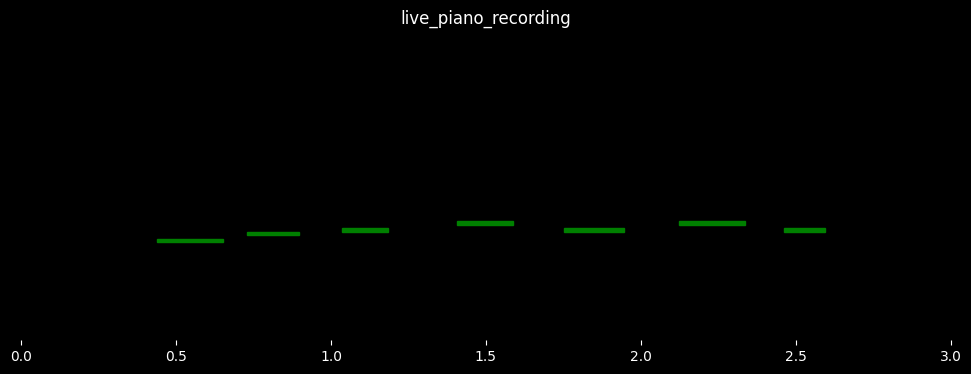

In [28]:
draw_midi(outfile)

In [29]:
def play_midi_file(midi_file_path, output_port_name):
    """
    Play a MIDI file through the specified MIDI output port.

    Parameters:
    - midi_file_path: The path to the MIDI file to be played.
    - output_port_name: The name of the MIDI output port.
    """
    # Load the MIDI file
    mid = MidiFile(midi_file_path)
    
    # Open the MIDI output port
    with mido.open_output(output_port_name) as outport:
        print(f"Playing {midi_file_path} on {output_port_name}...")
        for msg in mid.play():
            if not msg.is_meta:
                outport.send(msg)

    print("Playback finished.")

In [30]:
play_midi_file('../recordings/live_piano_recording.mid', 'Disklavier')

Playing ../recordings/live_piano_recording.mid on Disklavier...
Playback finished.
